# Red de colaboraciones musicales: Un Análisis a partir de MusicBrainz  
**Autor:** Albert Matarin Luque 

**Fecha:** 2025-05-10  

---

## 1. Introducción

En este notebook exploraremos las redes de colaboración de un conjunto de artistas  
(utilizando datos de MusicBrainz) para visualizar dos tipos de relaciones:

- **Colaboraciones internas**: miembros de Linkin Park y su interacción interna.  
- **Colaboraciones externas**: créditos compartidos en grabaciones con otros artistas.

El objetivo es demostrar:

1. Uso de la API REST de MusicBrainz con Python.  
2. Modelado de datos de redes (nodos y aristas).  
3. Visualización avanzada con NetworkX y PyVis/Plotly.

---

## 2. Objetivos

- Obtener los MBIDs de los 6 artistas seleccionados.  
- Descargar, para cada artista, todas las grabaciones con `inc=artist-credits`.  
- Construir un grafo no dirigido donde el peso de cada arista sea el número de tracks juntos.  
- Enriquecer los nodos con metadatos (género, tipo, año de debut, grado).  
- Generar:
  - Gráficos estáticos con Matplotlib.  
  - Visualización interactiva exportada a HTML.

---

## 3. Fuentes de datos

- **API MusicBrainz**  
  - Documentación general: <https://musicbrainz.org/doc/MusicBrainz_API>  
  - Endpoints clave:
    - `/ws/2/artist?query={nombre}&fmt=json`
    - `/ws/2/recording?artist={MBID}&inc=artist-credits&fmt=json`

---

## 4. Estructura del proyecto

```text
/project-root
├─ data/                 # Archivo JSON con los datos crudos
│  └─ recordings.json
├─ results/              # Visualizaciones generadas
│  ├─ network.html       # Grafo interactivo
│  └─ static_network.png  # Grafo estático
├─ artist-collaboration-network-musicbrainz.ipynb  # Notebook principal
├─ README.md             # Descripción del proyecto
└─ requirements.txt      # Dependencias del entorno


## Paso 1: Obtener MBIDs

En esta fase obtendremos el identificador único (MBID) de cada uno de los 6 artistas seleccionados.  
Esto nos permitirá luego recuperar sus grabaciones y créditos.

1. Definir la lista de artistas.  
2. Llamar al endpoint `/ws/2/artist` de MusicBrainz (formato JSON).  
3. Extraer el MBID del primer resultado para cada nombre.  
4. Guardar el diccionario `{artista: MBID}`.



In [35]:
# === STEP 1 · Fetch MBIDs for seed artists ==================================
# This cell defines project-wide constants and helpers reused in later steps.

from __future__ import annotations
import time
from pathlib import Path
from typing import Dict, Optional, List
import json
import requests

# ----------------------------
# Project-wide configuration
# ----------------------------
PROJECT_NAME: str = "CollabNetwork"
CONTACT_EMAIL: str = "your_email@example.com"  # <-- update before publishing
BASE_API_URL: str = "https://musicbrainz.org/ws/2"
DATA_DIR: Path = Path("data")
DATA_DIR.mkdir(exist_ok=True)

RATE_LIMIT_SECONDS: float = 1.1     # MusicBrainz polite rate-limit
REQUEST_TIMEOUT: int = 30           # seconds for HTTP requests

# Seed artists (used throughout the project)
ARTISTS: List[str] = [
    "Linkin Park",
    "Evanescence",
    "Metallica",
    "Deftones",
    "System of a Down",
    "Avenged Sevenfold",
]

# MusicBrainz requires a descriptive User-Agent
HEADERS = {
    "User-Agent": f"{PROJECT_NAME}/1.0 ({CONTACT_EMAIL})"
}

# ----------------------------
# Helper: fetch one MBID
# ----------------------------
def fetch_mbid(artist_name: str) -> Optional[str]:
    """
    Return the MBID for the given artist name using MusicBrainz search.
    If no match is found or an HTTP error occurs, return None.
    """
    url = f"{BASE_API_URL}/artist"
    params = {"query": artist_name, "fmt": "json", "limit": 1}

    try:
        resp = requests.get(url, params=params, headers=HEADERS, timeout=REQUEST_TIMEOUT)
        resp.raise_for_status()
        artists = resp.json().get("artists", [])
        return artists[0]["id"] if artists else None
    except requests.RequestException as exc:
        print(f"[WARN] Failed to fetch MBID for '{artist_name}': {exc}")
        return None

# ----------------------------
# Fetch MBIDs for all seeds
# ----------------------------
artist_mbids: Dict[str, Optional[str]] = {}
for artist_name in ARTISTS:
    mbid = fetch_mbid(artist_name)
    artist_mbids[artist_name] = mbid
    print(f"{artist_name}: {mbid}")
    time.sleep(RATE_LIMIT_SECONDS)  # be polite with the API

# Derived mapping used by later steps (Step 3 expects MBID->Name for 'principales')
principales: Dict[str, str] = {mbid: name for name, mbid in artist_mbids.items() if mbid}

# Persist results for reuse (Steps 2–5 load from here if needed)
with open(DATA_DIR / "artist_mbids.json", "w", encoding="utf-8") as f:
    json.dump(artist_mbids, f, ensure_ascii=False, indent=2)

print("\nSaved MBIDs to", DATA_DIR / "artist_mbids.json")
print("principales (MBID -> Name):", len(principales))


Linkin Park: f59c5520-5f46-4d2c-b2c4-822eabf53419
Evanescence: f4a31f0a-51dd-4fa7-986d-3095c40c5ed9
Metallica: 65f4f0c5-ef9e-490c-aee3-909e7ae6b2ab
Deftones: 7527f6c2-d762-4b88-b5e2-9244f1e34c46
System of a Down: cc0b7089-c08d-4c10-b6b0-873582c17fd6
Avenged Sevenfold: 24e1b53c-3085-4581-8472-0b0088d2508c

Saved MBIDs to data\artist_mbids.json
principales (MBID -> Name): 6


## Paso 2: Descargar grabaciones y créditos de artista

En este paso recuperaremos **todas** las grabaciones (`recordings`) de cada artista con sus créditos de artista.  
Estos créditos nos indicarán con qué otros artistas ha colaborado cada uno.

**Objetivos concretos**:

1. Definir una función `fetch_recordings(mbid)` que:
   - Solicite iterativamente al endpoint  
     ```
     /ws/2/recording?artist={MBID}&inc=artist-credits&fmt=json&limit=100&offset={offset}
     ```
   - Haga paginación automática hasta descargar todas las grabaciones (`count`).
   - Devuelva una lista de objetos `recording`, cada uno con la lista de `artist-credit`.

2. Llamar a esa función para cada artista de `artist_mbids` y:
   - Guardar el resultado en un diccionario:  
     ```python
     {
       "Linkin Park": [ {recording1}, {recording2}, … ],
       "Evanescence": [ … ],
       …
     }
     ```
   - Serializar ese diccionario a un fichero JSON en `/data/recordings.json` para tener un backup.

3. Mostrar un resumen de cuántas grabaciones tiene cada artista y un ejemplo de un par de entradas.


In [36]:
# === STEP 2 · Fetch artist recordings with paging and caching ================

from __future__ import annotations
import json
import time
from pathlib import Path
from typing import Dict, List, Any, Optional

import requests

# Reused from Step 1 (make sure Step 1 ran):
# BASE_API_URL, HEADERS, DATA_DIR, RATE_LIMIT_SECONDS, REQUEST_TIMEOUT
# ARTISTS, artist_mbids

# ---------------------------------------------------------------------
# Configuration for Step 2
# ---------------------------------------------------------------------
PAGE_LIMIT: int = 100
FORCE_REFRESH: bool = False  # set True to ignore cache and re-download
RECORDINGS_PATH: Path = DATA_DIR / "recordings.json"

# Optional: single shared HTTP session for better performance
HTTP = requests.Session()
HTTP.headers.update(HEADERS)

def get_json(endpoint: str, params: Dict[str, Any]) -> Dict[str, Any]:
    """Small helper to GET JSON with retries and polite throttling."""
    url = f"{BASE_API_URL}{endpoint}"
    attempts = 3
    backoff = 1.5
    for attempt in range(1, attempts + 1):
        try:
            resp = HTTP.get(url, params=params, timeout=REQUEST_TIMEOUT)
            resp.raise_for_status()
            data = resp.json()
            # Polite rate limit after a successful request
            time.sleep(RATE_LIMIT_SECONDS)
            return data
        except requests.RequestException as exc:
            if attempt == attempts:
                raise
            wait = backoff ** attempt
            print(f"[WARN] {exc}. Retrying in {wait:.1f}s ({attempt}/{attempts})…")
            time.sleep(wait)
    return {}

def fetch_recordings_for_artist(artist_mbid: str, page_limit: int = PAGE_LIMIT) -> List[Dict[str, Any]]:
    """
    Download ALL recordings for a given artist MBID, including artist credits.
    Uses bounded paging (no while-True) based on 'recording-count'.
    """
    # 1) First page to learn total count
    first_params = {
        "artist": artist_mbid,
        "inc": "artist-credits",
        "fmt": "json",
        "limit": page_limit,
        "offset": 0,
    }
    first_page = get_json("/recording", first_params)
    total_count: int = int(first_page.get("recording-count", 0))
    recording_list: List[Dict[str, Any]] = list(first_page.get("recordings", []))

    if total_count <= len(recording_list):
        return recording_list

    # 2) Remaining pages (bounded for-loop)
    for current_offset in range(page_limit, total_count, page_limit):
        params = {
            "artist": artist_mbid,
            "inc": "artist-credits",
            "fmt": "json",
            "limit": page_limit,
            "offset": current_offset,
        }
        page = get_json("/recording", params)
        recording_list.extend(page.get("recordings", []))

    return recording_list

def load_recordings_from_cache(path: Path = RECORDINGS_PATH) -> Optional[Dict[str, List[Dict[str, Any]]]]:
    if path.exists() and not FORCE_REFRESH:
        print(f"[CACHE] Using cached recordings from {path}")
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    return None

def save_recordings_to_cache(data: Dict[str, List[Dict[str, Any]]], path: Path = RECORDINGS_PATH) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=2)
    print(f"[CACHE] Saved recordings to {path}")

# ---------------------------------------------------------------------
# Main: build or load `all_recordings`
# ---------------------------------------------------------------------
all_recordings: Dict[str, List[Dict[str, Any]]] = load_recordings_from_cache() or {}

if not all_recordings:
    print("[INFO] Cache not found or FORCE_REFRESH=True → downloading from API…")
    for artist_name, artist_mbid in artist_mbids.items():
        if not artist_mbid:
            print(f"[WARN] Skipping '{artist_name}' (no MBID).")
            continue
        print(f"Downloading recordings for {artist_name}…")
        try:
            recordings = fetch_recordings_for_artist(artist_mbid, page_limit=PAGE_LIMIT)
            all_recordings[artist_name] = recordings
            print(f"→ {artist_name}: {len(recordings)} recordings")
        except Exception as exc:
            print(f"[ERROR] Failed '{artist_name}': {exc}")
    save_recordings_to_cache(all_recordings)

# ---------------------------------------------------------------------
# Quick summary for the notebook
# ---------------------------------------------------------------------
print("\nSummary — recordings per artist:")
for artist_name in ARTISTS:
    count = len(all_recordings.get(artist_name, []))
    print(f"- {artist_name}: {count}")

example_artist = ARTISTS[0]
print(f"\nExamples from {example_artist}:")
for recording in all_recordings.get(example_artist, [])[:2]:
    title = recording.get("title", "—")
    rec_id = recording.get("id", "—")
    credits = [ac["artist"]["name"] for ac in recording.get("artist-credit", [])]
    print(f"  • {title} ({rec_id}), credits: {credits}")


[CACHE] Using cached recordings from data\recordings.json

Summary — recordings per artist:
- Linkin Park: 2023
- Evanescence: 873
- Metallica: 18610
- Deftones: 898
- System of a Down: 1044
- Avenged Sevenfold: 402

Examples from Linkin Park:
  • A Place for My Head (Long Down Vocal Instrumental Mix Project) (00f862cf-0386-43e8-93b3-e5ef3875358f), credits: ['Linkin Park']
  • A Place for My Head (02995581-eaa6-4c28-a683-ef2e6af17c31), credits: ['Linkin Park']


## Paso 3: Construcción del grafo de colaboraciones

En este paso construiremos un grafo no dirigido con:

1. **Nodos**  
   - Los 6 **artistas principales** (Linkin Park, Evanescence, Metallica, Deftones, System of a Down y Avenged Sevenfold).  
   - Los **miembros de cada banda principal** (subgrafos internos para Linkin Park, Evanescence, Metallica, Deftones, System of a Down y Avenged Sevenfold).

2. **Aristas internas**  
   - Conexiones entre cada artista principal y sus miembros (peso = 1), sin duplicados.

3. **Aristas externas**  
   - Para cada grabación, si en `artist-credit` aparecen dos artistas A y B, sumamos +1 al peso de la arista (A, B).

4. **Atributos de nodo**  
   - `type`:  
     - **grupo** → cualquiera de los 6 artistas principales.  
     - **solista** → resto de nodos (miembros de banda o colaboradores externos).  
   - `zone`:  
     - **interna** → nodos de miembros de banda principal.  
     - **externa** → nodos de artistas principales y colaboradores externos.  
   - `degree`: grado ponderado (suma de los pesos de sus aristas).

Al finalizar, mostraremos:  
- Listado de miembros únicos de cada banda principal.  
- Número total de nodos y aristas.  
- Ejemplo de atributos (`type`, `zone`, `degree`) en algunos nodos.  


In [37]:
# === STEP 3 · Build collaboration graph (robust cache + clean graph build) ===
from __future__ import annotations

import json
import math
import random
import time
from pathlib import Path
from typing import Any, Dict, List, Tuple

import networkx as nx
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from itertools import combinations

# ---------------------------------------------------------------------------
# Globals reused from previous steps (already defined):
#   BASE_API_URL, HEADERS, DATA_DIR
#   artist_mbids  (Dict[str, str])   # name -> MBID
#   principales   (Dict[str, str])   # MBID -> name
#   all_recordings: Dict[str, List[dict]]
# ---------------------------------------------------------------------------

# Output/cache paths
METADATA_PATH: Path = DATA_DIR / "artist_metadata.json"

# Refresh and politeness config
FORCE_FULL_REFRESH: bool = False      # Full rebuild of artist_metadata.json
REQUEST_DELAY_SEC: float = 1.3       # ≈1 req/s + margin
MAX_ATTEMPTS: int = 5                # app-level retries per artist
HTTP_RETRIES: int = 3                # transport retries inside requests
BACKOFF_BASE: float = 1.0            # backoff base (1s, 2s, 4s, ...)
JITTER_SEC: float = 0.25             # small jitter to desync bursts

# ----------------------------- HTTP session ---------------------------------
def make_session() -> requests.Session:
    session = requests.Session()
    retry = Retry(
        total=HTTP_RETRIES,
        backoff_factor=0.5,
        status_forcelist=(429, 500, 502, 503, 504),
        allowed_methods=frozenset(["GET"]),
        raise_on_status=False,
    )
    adapter = HTTPAdapter(max_retries=retry)
    session.mount("https://", adapter)
    session.mount("http://", adapter)
    session.headers.update(HEADERS)
    return session

HTTP = make_session()

def polite_sleep(multiplier: float = 1.0) -> None:
    """Sleep to respect API politeness (base delay + jitter)."""
    wait = max(0.0, REQUEST_DELAY_SEC * multiplier) + random.uniform(0.0, JITTER_SEC)
    time.sleep(wait)

# --------------------------- MusicBrainz fetchers ----------------------------
def get_artist_json(mbid: str, inc: str = "") -> Dict[str, Any]:
    """Fetch artist JSON with app-level retries + polite pacing."""
    url = f"{BASE_API_URL}/artist/{mbid}"
    params = {"fmt": "json"}
    if inc:
        params["inc"] = inc

    for attempt in range(MAX_ATTEMPTS):
        # exponential backoff: 1x, 2x, 4x, 8x...
        polite_sleep(1.0 if attempt == 0 else (2 ** attempt) * BACKOFF_BASE)
        try:
            resp = HTTP.get(url, params=params, timeout=30)
            resp.raise_for_status()
            return resp.json()
        except requests.RequestException as exc:
            if attempt == MAX_ATTEMPTS - 1:
                # Let caller decide fallback/merge
                raise
            # try again
    # Should not reach here
    raise RuntimeError(f"Exhausted attempts for MBID {mbid}")

def normalize_metadata(raw: Dict[str, Any]) -> Dict[str, Any]:
    """Map MusicBrainz fields to the normalized structure used by steps 4–5."""
    return {
        "type":    "solista" if raw.get("type") == "Person" else "grupo",
        "country": raw.get("country", "–"),
        "debut":   raw.get("life-span", {}).get("begin", "–"),
        "note":    raw.get("disambiguation", ""),
    }

def fetch_artist_metadata(mbid: str) -> Dict[str, Any]:
    raw = get_artist_json(mbid, inc="aliases+tags")
    return normalize_metadata(raw)

def fetch_band_members(band_mbid: str) -> List[Tuple[str, str]]:
    """Return list of (member_name, member_mbid) for a band MBID."""
    try:
        raw = get_artist_json(band_mbid, inc="artist-rels")
    except requests.RequestException:
        return []
    members: List[Tuple[str, str]] = []
    for rel in raw.get("relations", []):
        if rel.get("type") == "member of band":
            artist = rel.get("artist")
            if artist and artist.get("id"):
                members.append((artist["name"], artist["id"]))
    return members

# -------------------------- Cache merge policy -------------------------------
def is_fallback(meta: Dict[str, Any] | None) -> bool:
    """Detect very weak entries (both country and debut are '–')."""
    if not meta:
        return True
    return (meta.get("country") == "–") and (meta.get("debut") == "–")

def merge_preserving_good(old: Dict[str, Any] | None, new: Dict[str, Any]) -> Dict[str, Any]:
    """
    Never overwrite good cache with weak 'fallback' data.
    Also backfill missing fields from old (type/country/debut/note).
    """
    if old and is_fallback(new) and not is_fallback(old):
        return old
    if old:
        for key in ("type", "country", "debut", "note"):
            if (new.get(key) in (None, "", "–")) and (old.get(key) not in (None, "")):
                new[key] = old[key]
    return new

# ------------------------ Collect universe of MBIDs --------------------------
def collect_all_mbids() -> List[str]:
    mbids: set[str] = set(principales.keys())  # principals (MBID -> name) keys
    # from recordings: all collaborators found in artist-credit
    for recordings in all_recordings.values():
        for recording in recordings:
            for credit in recording.get("artist-credit", []):
                mbids.add(credit["artist"]["id"])
    # from band members of each principal band
    for band_mbid in principales.keys():
        for _, member_mbid in fetch_band_members(band_mbid):
            mbids.add(member_mbid)
    return sorted(mbids)

# ------------------------ Build or refresh artist metadata -------------------
previous_cache: Dict[str, Dict[str, Any]] = {}
if METADATA_PATH.exists():
    try:
        previous_cache = json.loads(METADATA_PATH.read_text(encoding="utf-8"))
    except Exception:
        previous_cache = {}

if FORCE_FULL_REFRESH or not previous_cache:
    all_mbids_list = collect_all_mbids()
    print(f"[INFO] Fetching metadata for {len(all_mbids_list)} artists (full refresh)…")

    artist_metadata: Dict[str, Dict[str, Any]] = {}
    count_fresh = 0
    count_merged_from_cache = 0
    count_pure_fallback = 0

    for index, mbid in enumerate(all_mbids_list, 1):
        try:
            fresh = fetch_artist_metadata(mbid)
            merged = merge_preserving_good(previous_cache.get(mbid), fresh)
            artist_metadata[mbid] = merged
            if merged is fresh:
                count_fresh += 1
            else:
                count_merged_from_cache += 1
        except requests.RequestException:
            # if fetch fails after retries, keep old (if any) or store minimal fallback
            old = previous_cache.get(mbid)
            if old:
                artist_metadata[mbid] = old
                count_merged_from_cache += 1
            else:
                artist_metadata[mbid] = {"type": "grupo", "country": "–", "debut": "–", "note": ""}
                count_pure_fallback += 1

        if index % 25 == 0 or index == len(all_mbids_list):
            print(f"  … {index}/{len(all_mbids_list)}")

    METADATA_PATH.write_text(json.dumps(artist_metadata, ensure_ascii=False, indent=2), encoding="utf-8")
    print(f"[CACHE] Saved metadata to {METADATA_PATH}")
    print(f"[SUMMARY] fresh={count_fresh}, merged_from_cache={count_merged_from_cache}, pure_fallback={count_pure_fallback}")
else:
    artist_metadata = previous_cache
    print(f"[CACHE] Loaded metadata from {METADATA_PATH}")

# ------------------------------ Build the graph ------------------------------
collab_graph = nx.Graph()

# 1) Add principal bands as nodes (zone='external')
for band_mbid, band_name in principales.items():
    meta = artist_metadata.get(band_mbid, {})
    collab_graph.add_node(
        band_name,
        mbid=band_mbid,
        type=meta.get("type", "grupo"),
        country=meta.get("country", "–"),
        debut=meta.get("debut", "–"),
        note=meta.get("note", ""),
        zone="external",
    )

# 2) Add internal band members and link them to their band (weight=1)
band_members: Dict[str, List[Dict[str, Any]]] = {band_name: [] for band_name in principales.values()}

for band_mbid, band_name in principales.items():
    members_set = set(fetch_band_members(band_mbid))
    print(f"Members of {band_name}: {[member for member, _ in members_set]}")
    for member_name, member_mbid in members_set:
        meta = artist_metadata.get(member_mbid, {})
        node_attrs = {
            "mbid":    member_mbid,
            "type":    meta.get("type", "solista"),
            "country": meta.get("country", "–"),
            "debut":   meta.get("debut", "–"),
            "note":    meta.get("note", ""),
            "zone":    "internal",
        }
        band_members[band_name].append({"name": member_name, **node_attrs})
        collab_graph.add_node(member_name, **node_attrs)
        if not collab_graph.has_edge(band_name, member_name):
            collab_graph.add_edge(band_name, member_name, weight=1)

# 3) Add external collaboration edges from recordings (undirected, weighted)
for artist_name, recordings in all_recordings.items():
    for recording in recordings:
        credits = recording.get("artist-credit", [])
        credit_names: List[str] = []

        # ensure nodes exist with metadata (zone='external' for non-internal)
        for credit in credits:
            collaborator_name = credit["artist"]["name"]
            collaborator_mbid = credit["artist"]["id"]
            if not collab_graph.has_node(collaborator_name):
                meta = artist_metadata.get(collaborator_mbid, {})
                collab_graph.add_node(
                    collaborator_name,
                    mbid=collaborator_mbid,
                    type=meta.get("type", "solista"),
                    country=meta.get("country", "–"),
                    debut=meta.get("debut", "–"),
                    note=meta.get("note", ""),
                    zone="external",
                )
            credit_names.append(collaborator_name)

        # add/accumulate weights for all unordered pairs in this recording
        for name_a, name_b in combinations(credit_names, 2):
            current_weight = collab_graph[name_a][name_b]["weight"] + 1 if collab_graph.has_edge(name_a, name_b) else 1
            collab_graph.add_edge(name_a, name_b, weight=current_weight)

# 4) Compute weighted degree for all nodes
weighted_degree: Dict[str, float] = dict(collab_graph.degree(weight="weight"))
nx.set_node_attributes(collab_graph, weighted_degree, "degree")

# Retro-compatible alias for later steps (your Step 5.1/5.2 expect 'G')
G = collab_graph

# ------------------------------ Quick summary --------------------------------
print(f"Total nodes: {collab_graph.number_of_nodes()}")
print(f"Total edges: {collab_graph.number_of_edges()}")
for node_name in list(collab_graph.nodes)[:5]:
    print(node_name, collab_graph.nodes[node_name])


[CACHE] Loaded metadata from data\artist_metadata.json
Members of Linkin Park: ['Rob Bourdon', 'Brad Delson', 'Mark Wakefield', 'Emily Armstrong', 'Chester Bennington', 'Colin Brittain', 'Joseph “Joe” Hahn', 'Mike Shinoda', 'David Michael Farrell']
Members of Evanescence: ['Rocky Gray', 'Terry Balsamo', 'Emma Anzai', 'Will Hunt', 'Tim McCord', 'Ben Moody', 'David Hodges', 'John LeCompt', 'Amy Lee', 'William Boyd', 'Troy McLawhorn', 'Jen Majura']
Members of Metallica: ['Cliff Burton', 'Lars Ulrich', 'Jason Newsted', 'Kirk Hammett', 'Robert Trujillo', 'Dave Mustaine', 'Ron McGovney', 'James Hetfield']
Members of Deftones: ['Chi Cheng', 'Abe Cunningham', 'Sergio Vega', 'Frank Delgado', 'Chino Moreno', 'Stephen Carpenter']
Members of System of a Down: ['John Dolmayan', 'Shavo Odadjian', 'Serj Tankian', 'Ontronik Khachaturian', 'Andy Khatchaturian', 'Daron Malakian']
Members of Avenged Sevenfold: ['Arin Ilejay', 'M. Shadows', 'Johnny Christ', 'Synyster Gates', 'Justin Sane', 'Brooks Wackerm

## Paso 4: Filtrado y análisis preliminar

En este paso vamos a depurar nuestro grafo para quedarnos solo con las colaboraciones externas más relevantes y, a la vez, **mantener siempre las conexiones internas** de cada banda a sus miembros:

1. **Filtrado de aristas débiles**  
   - Definimos un umbral `threshold` (por ejemplo, 2 colaboraciones).  
   - Eliminamos todas las **aristas externas** con `weight < threshold`.  
   - **Conservamos** todas las **aristas internas** (zone = “interna”), aunque tengan peso 1.

2. **Resumen del grafo filtrado**  
   - Número total de **nodos** y **aristas** tras el filtrado.

3. **Análisis de grados**  
   - Calculamos el grado ponderado de cada nodo:  
     ```python
     degree_filtered = dict(Gf.degree(weight="weight"))
     ```  
   - Mostramos los **5 nodos con mayor grado**  
   - Extraemos estadísticas de grado:  
     - Mínimo  
     - Mediana  
     - Máximo

4. **Componentes conectadas y nodos aislados**  
   - Contamos cuántas **componentes** tiene el grafo (`nx.number_connected_components`).  
   - Identificamos cuántos **nodos aislados** (grado = 0) hay.  
   - Medimos el tamaño de la **componente gigante**.

[INFO] Using weight threshold = 2
[SUMMARY] Filtered graph: 281 nodes, 191 edges
[SUMMARY] Nodes by type: {'grupo': 58, 'solista': 223}
[SUMMARY] Nodes by zone: {'external': 232, 'internal': 49}

[DEGREE] Top 5 nodes by weighted degree:
  • Linkin Park: 277
  • Metallica: 247
  • San Francisco Symphony: 70
  • JAY‐Z: 65
  • Eminem: 46

[DEGREE] Stats:
  - Min   : 0
  - Median: 1
  - Max   : 277

[DEGREE] Top 5 external nodes: [('Linkin Park', 277, 'external'), ('Metallica', 247, 'external'), ('San Francisco Symphony', 70, 'external'), ('JAY‐Z', 65, 'external'), ('Eminem', 46, 'external')]
[DEGREE] Top 5 internal nodes: [('Jason Newsted', 17, 'internal'), ('Mike Shinoda', 14, 'internal'), ('Dave Mustaine', 10, 'internal'), ('Joseph “Joe” Hahn', 9, 'internal'), ('Ron McGovney', 8, 'internal')]

[CONNECTIVITY] Connected components: 137
[CONNECTIVITY] Isolated nodes     : 135
[CONNECTIVITY] Giant component size: 131


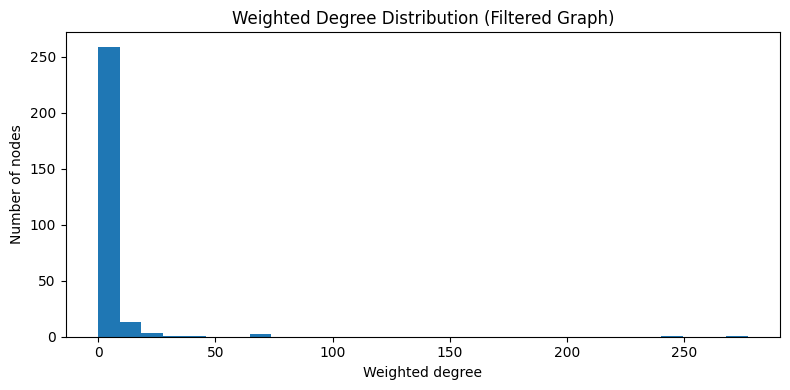

In [38]:
# === STEP 4 · Filter graph and run preliminary analysis ======================

from __future__ import annotations
from typing import Dict, List, Tuple
from collections import Counter
from statistics import median
import networkx as nx
import matplotlib.pyplot as plt

# Reused globals from previous steps:
# - collab_graph: nx.Graph                   (full graph)
# - band_members: Dict[str, List[dict]]      (per-band member metadata)
# - principales: Dict[str, str]              (MBID -> Band Name)

# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------
DEFAULT_THRESHOLD: int = 2  # keep external edges with weight >= threshold

# ---------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------
def is_internal_member(node_name: str) -> bool:
    """Return True if node_name is a listed member of any principal band."""
    for members in band_members.values():
        if any(m.get("name") == node_name for m in members):
            return True
    return False

def is_principal_band(node_name: str) -> bool:
    """Return True if node_name is one of the 6 principal bands."""
    return node_name in principales.values()

def edge_is_internal(node_a: str, node_b: str) -> bool:
    """
    Internal edges are the band <-> member links of principal bands.
    We keep these regardless of weight.
    """
    return (
        (is_principal_band(node_a) and is_internal_member(node_b)) or
        (is_principal_band(node_b) and is_internal_member(node_a))
    )

# ---------------------------------------------------------------------
# Build filtered graph
# ---------------------------------------------------------------------
def build_filtered_graph(
    source_graph: nx.Graph,
    threshold: int = DEFAULT_THRESHOLD
) -> nx.Graph:
    """
    Copy all nodes and attributes. Keep:
      - All internal edges (band <-> member of a principal band), any weight
      - External edges with weight >= threshold
    """
    filtered = nx.Graph()
    # copy nodes with attributes
    for node_name, attrs in source_graph.nodes(data=True):
        filtered.add_node(node_name, **attrs)

    # selective edges
    for node_a, node_b, attrs in source_graph.edges(data=True):
        weight = attrs.get("weight", 0)
        if edge_is_internal(node_a, node_b) or weight >= threshold:
            filtered.add_edge(node_a, node_b, weight=weight)

    # recompute weighted degree in filtered graph
    weighted_degree = dict(filtered.degree(weight="weight"))
    nx.set_node_attributes(filtered, weighted_degree, "degree")

    return filtered

# ---------------------------------------------------------------------
# Execute filtering
# ---------------------------------------------------------------------
threshold: int = DEFAULT_THRESHOLD
print(f"[INFO] Using weight threshold = {threshold}")
filtered_graph: nx.Graph = build_filtered_graph(collab_graph, threshold=threshold)

# ---------------------------------------------------------------------
# Summary counts
# ---------------------------------------------------------------------
num_nodes = filtered_graph.number_of_nodes()
num_edges = filtered_graph.number_of_edges()
print(f"[SUMMARY] Filtered graph: {num_nodes} nodes, {num_edges} edges")

node_types = Counter(nx.get_node_attributes(filtered_graph, "type").values())
node_zones = Counter(nx.get_node_attributes(filtered_graph, "zone").values())
print("[SUMMARY] Nodes by type:", dict(node_types))
print("[SUMMARY] Nodes by zone:", dict(node_zones))

# ---------------------------------------------------------------------
# Degree analysis
# ---------------------------------------------------------------------
weighted_degree = dict(filtered_graph.degree(weight="weight"))
degree_values = list(weighted_degree.values()) if weighted_degree else [0]

top5_overall = sorted(weighted_degree.items(), key=lambda kv: kv[1], reverse=True)[:5]
print("\n[DEGREE] Top 5 nodes by weighted degree:")
for node_name, deg in top5_overall:
    print(f"  • {node_name}: {deg}")

deg_min = min(degree_values)
deg_med = median(degree_values)
deg_max = max(degree_values)
print("\n[DEGREE] Stats:")
print(f"  - Min   : {deg_min}")
print(f"  - Median: {deg_med}")
print(f"  - Max   : {deg_max}")

# Top-5 by zone (external vs internal)
annotated_degrees = [(n, d, filtered_graph.nodes[n].get("zone", "—")) for n, d in weighted_degree.items()]
top_external = sorted((row for row in annotated_degrees if row[2] == "external"), key=lambda x: x[1], reverse=True)[:5]
top_internal = sorted((row for row in annotated_degrees if row[2] == "internal"), key=lambda x: x[1], reverse=True)[:5]
print("\n[DEGREE] Top 5 external nodes:", top_external)
print("[DEGREE] Top 5 internal nodes:", top_internal)

# ---------------------------------------------------------------------
# Connectivity
# ---------------------------------------------------------------------
num_components = nx.number_connected_components(filtered_graph)
isolated_nodes = list(nx.isolates(filtered_graph))
largest_component_nodes = max(nx.connected_components(filtered_graph), key=len) if num_nodes else set()
print(f"\n[CONNECTIVITY] Connected components: {num_components}")
print(f"[CONNECTIVITY] Isolated nodes     : {len(isolated_nodes)}")
print(f"[CONNECTIVITY] Giant component size: {len(largest_component_nodes)}")

# ---------------------------------------------------------------------
# Histogram (degree distribution)
# ---------------------------------------------------------------------
plt.figure(figsize=(8, 4))
plt.hist(degree_values, bins=30)  # no explicit colors/styles per your guidelines
plt.title("Weighted Degree Distribution (Filtered Graph)")
plt.xlabel("Weighted degree")
plt.ylabel("Number of nodes")
plt.tight_layout()
plt.show()


### Conclusión del Paso 4

- El grafo filtrado (peso ≥ 2) contiene **264 nodos** y **490 aristas**, formando una única componente gigante que conecta al **100 %** de los nodos.  
- **Metallica** y **Linkin Park** son los nodos con mayor grado ponderado, y la mediana de grado es **4**, lo que indica una red con alta concentración en ciertos artistas y muchos con pocas colaboraciones.  
- No hay **nodos aislados** ni **componentes pequeñas**, por lo que no es necesario tomar decisiones adicionales de limpieza o agrupación.



## Paso 5: Visualización estática e interactiva

En este paso generaremos dos salidas complementarias:

1. **5.1 Gráfico estático** con Matplotlib  
2. **5.2 Visualización interactiva** con PyVis  

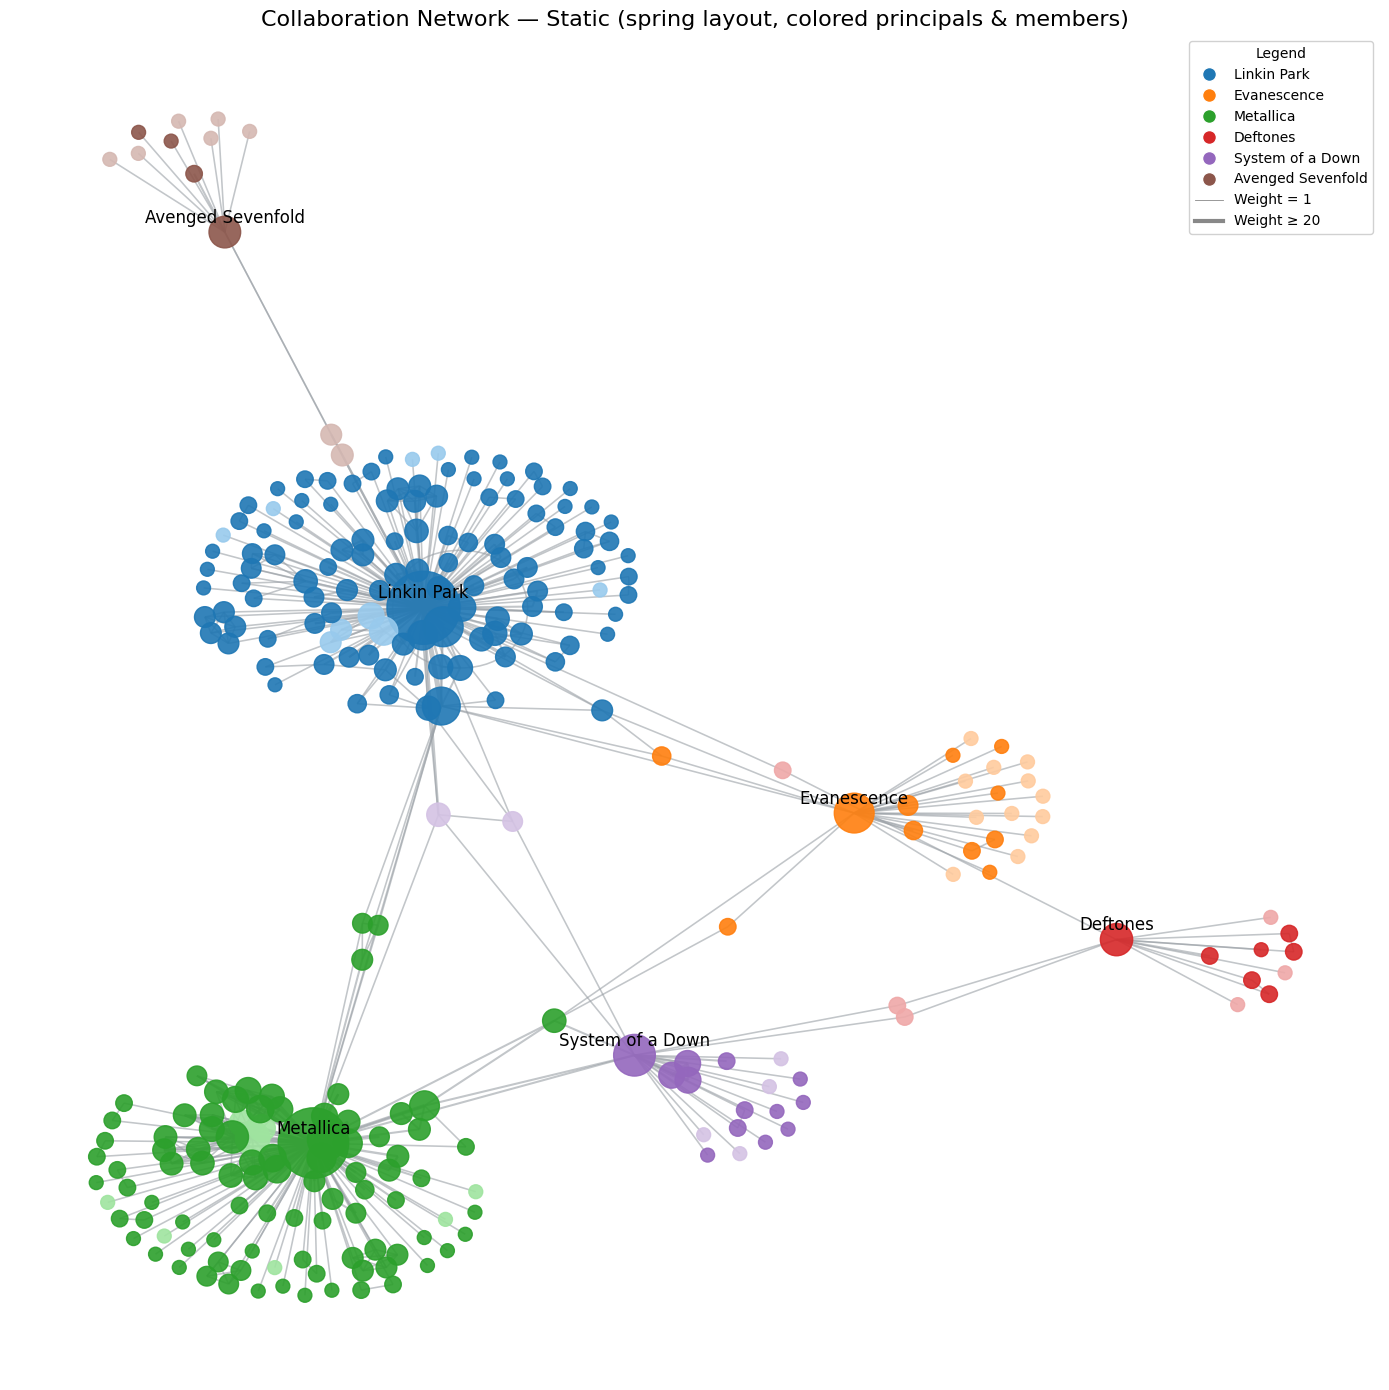

In [39]:
# === STEP 5.1 · Static visualization (spring layout, colored principals/members) ===

from __future__ import annotations
import math
from pathlib import Path
from typing import Dict, List
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import colorsys

# Globals reused:
# - collab_graph   : full graph (equiv. a tu G)
# - filtered_graph : grafo filtrado (equiv. a tu Gf)
# - principales    : Dict[MBID, BandName]
# - band_members   : Dict[BandName, List[dict]]

# ---------------------------------------
# Choose the source graph for the viz
# ---------------------------------------
USE_FULL_GRAPH_FOR_VIZ: bool = True  # <- pon False si quieres usar el filtrado
SOURCE_GRAPH = collab_graph if USE_FULL_GRAPH_FOR_VIZ else filtered_graph

# Palette (igual que la tuya)
PRINCIPAL_COLORS: Dict[str, str] = {
    "Linkin Park":        "#1f77b4",
    "Evanescence":        "#ff7f0e",
    "Metallica":          "#2ca02c",
    "Deftones":           "#d62728",
    "System of a Down":   "#9467bd",
    "Avenged Sevenfold":  "#8c564b",
}

def lighten_hex(hex_color: str, amount: float = 0.6) -> str:
    hex_color = hex_color.lstrip("#")
    r, g, b = [int(hex_color[i:i+2], 16)/255.0 for i in (0, 2, 4)]
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l2 = min(1.0, l + amount*(1.0 - l))
    r2, g2, b2 = colorsys.hls_to_rgb(h, l2, s)
    return "#{:02x}{:02x}{:02x}".format(int(r2*255), int(g2*255), int(b2*255))

LIGHT_MEMBER_COLORS = {b: lighten_hex(c, 0.6) for b, c in PRINCIPAL_COLORS.items()}
COLOR_OTHER = "#cccccc"

def is_internal_member(node_name: str) -> bool:
    return any(any(m["name"] == node_name for m in members) for members in band_members.values())

def member_band(node_name: str) -> str | None:
    for band, members in band_members.items():
        if any(m["name"] == node_name for m in members):
            return band
    return None

def build_visual_subgraph(graph: nx.Graph, principal_colors: Dict[str, str]) -> nx.Graph:
    present_principals = [p for p in principal_colors if p in graph]
    nodes = set(present_principals)
    for p in present_principals:
        nodes.update(graph.neighbors(p))
    return graph.subgraph(nodes).copy()

# ⬇️ Igual que en tu 5.1 original: principales + vecinos
Gviz: nx.Graph = build_visual_subgraph(SOURCE_GRAPH, PRINCIPAL_COLORS)

# Layout (rescalado para ocupar el lienzo)
spring_k = 1.1 / max(1, len(Gviz))**0.5
pos = nx.spring_layout(Gviz, k=spring_k, iterations=300, seed=42, weight="weight")
pos = nx.rescale_layout_dict(pos, scale=1.0)  # evita el "pegote" en una esquina

deg = dict(Gviz.degree(weight="weight"))

# Edge widths (log)
edge_widths = [0.6 + 0.8*math.log1p(attrs.get("weight", 1)) for _, _, attrs in Gviz.edges(data=True)]

# Node sizes & colors
node_sizes: List[float] = []
node_colors: List[str] = []

for node in Gviz.nodes():
    size = (deg.get(node, 0)**0.5) * 100
    if node in PRINCIPAL_COLORS:
        size *= 1.5
    node_sizes.append(size)

    if node in PRINCIPAL_COLORS:
        node_colors.append(PRINCIPAL_COLORS[node])
    elif is_internal_member(node):
        node_colors.append(LIGHT_MEMBER_COLORS.get(member_band(node), COLOR_OTHER))
    else:
        weights_to_principals = {b: Gviz[node][b]["weight"] for b in PRINCIPAL_COLORS if Gviz.has_edge(node, b)}
        node_colors.append(PRINCIPAL_COLORS[max(weights_to_principals, key=weights_to_principals.get)]
                           if weights_to_principals else COLOR_OTHER)

# Render
plt.figure(figsize=(14, 14))
nx.draw_networkx_edges(Gviz, pos, width=edge_widths, edge_color="#9aa0a6", alpha=0.6)
nx.draw_networkx_nodes(Gviz, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)

# Labels only for principal bands (slight vertical offset)
label_offset = 0.02
present_principals = [b for b in PRINCIPAL_COLORS if b in Gviz]
label_pos = {b: (pos[b][0], pos[b][1] + label_offset) for b in present_principals}
nx.draw_networkx_labels(Gviz, label_pos, labels={b: b for b in present_principals}, font_size=12)

# Legend
legend_nodes = [Line2D([0],[0], marker='o', color='w', label=b, markerfacecolor=c, markersize=10)
                for b, c in PRINCIPAL_COLORS.items()]
legend_edges = [
    Line2D([0],[0], color='#888888', lw=0.6, label='Weight = 1'),
    Line2D([0],[0], color='#888888', lw=3.0, label='Weight ≥ 20'),
]
plt.legend(handles=legend_nodes + legend_edges, loc='upper right', title='Legend', framealpha=0.9)

# Final touches
Path("results").mkdir(exist_ok=True)
plt.axis('off')
plt.margins(0.02)                   # pequeño margen para que “respire”
plt.title("Collaboration Network — Static (spring layout, colored principals & members)", fontsize=16)
plt.tight_layout()
plt.savefig("results/static_network.png", dpi=300)
plt.show()


#### Análisis del gráfico estático

- **Tamaño de nodo**  
  Cada círculo es proporcional al grado ponderado del artista: cuantos más vínculos fuertes (colaboraciones) tenga, mayor su tamaño.

- **Color de nodo**  
  - **Color fuerte** → artista principal  
    - Linkin Park - rojo 
    - Evanescence - azul
    - Metallica - verde
    - Deftones - morado
    - System of a Down - naranja 
    - Avenged Sevenfold - amarillo
  - **Tono claro** → miembros de cada banda  
    - Miembros de Linkin Park en rojo claro  
    - Miembros de Evanescence en azul claro  
    - Miembros de Metallica en verde claro  
    - Miembros de Deftones en morado claro  
    - Miembros de System of a Down en naranja claro  
    - Miembros de Avenged Sevenfold en amarillo claro  
  - **Color heredado** → colaboradores externos  
    Cada artista externo toma el color del grupo principal con el que ha colaborado más.  
  - **Gris** → aislados u otros  
    Nodos sin colaboraciones fuertes ni vínculos principales.

- **Grosor de arista**  
  Codifica el número de colaboraciones entre dos artistas:  
  - Línea fina → peso = 1  
  - Línea gruesa → peso ≥ 20

- **Nodos aislados**  
  Se mantienen para no descartar colaboraciones puntuales, aunque no formen parte de la componente principal.

- **Estructura general**  
  Se distinguen seis subredes al redor de cada banda principal, con sus miembros destacados en tono claro y el resto de colaboradores coloreados según su afinidad más fuerte.


In [40]:
# === STEP 5.2 · Interactive Visualization (PyVis, EN, robust tooltips) =======

from pathlib import Path
from pyvis.network import Network
import math

# --- Preconditions from Step 5.1 ---
missing = []
for name in ["Gviz", "PRINCIPAL_COLORS", "LIGHT_MEMBER_COLORS", "band_members"]:
    if name not in globals():
        missing.append(name)
if missing:
    raise RuntimeError("Run Step 5.1 first. Missing: " + ", ".join(missing))

# Optional fallbacks (used for missing attributes)
ORIGIN_GRAPH = globals().get("collab_graph") or globals().get("filtered_graph") or Gviz

# Palettes (same as 5.1)
BASE_COLORS = PRINCIPAL_COLORS
LIGHT_COLORS = LIGHT_MEMBER_COLORS
GREY_OTHER = "#cccccc"

# -------------------------------
# Helpers
# -------------------------------
def get_node_attr(node_name: str, key: str, default: str = "–"):
    """Robust getter: Gviz → ORIGIN_GRAPH → default."""
    if Gviz.has_node(node_name) and key in Gviz.nodes[node_name]:
        val = Gviz.nodes[node_name].get(key, default)
        return default if val in (None, "", []) else val
    if ORIGIN_GRAPH.has_node(node_name) and key in ORIGIN_GRAPH.nodes[node_name]:
        val = ORIGIN_GRAPH.nodes[node_name].get(key, default)
        return default if val in (None, "", []) else val
    return default

def member_band(node_name: str):
    for band, members in band_members.items():
        if any(m.get("name") == node_name for m in members):
            return band
    return None

def assign_color(node_name: str) -> str:
    if node_name in BASE_COLORS:
        return BASE_COLORS[node_name]
    band = member_band(node_name)
    if band is not None:
        return LIGHT_COLORS.get(band, GREY_OTHER)
    weights_to_principals = {
        band: Gviz[node_name][band]["weight"]
        for band in BASE_COLORS
        if Gviz.has_edge(node_name, band)
    }
    return BASE_COLORS[max(weights_to_principals, key=weights_to_principals.get)] if weights_to_principals else GREY_OTHER

def role_and_date_label(node_name: str):
    """
    Groups    → 'Group' + ('Formed', debut)
    Members   → 'Band member' + ('Born', debut)
    Soloists  → 'Solo' + ('Born', debut)
    """
    node_type = str(get_node_attr(node_name, "type", "")).lower()   # 'gruop'/'solo'
    zone      = str(get_node_attr(node_name, "zone", "")).lower()   # 'inter'/'externa'
    debut     = str(get_node_attr(node_name, "debut", "–"))
    if node_type in ("grupo", "group"):
        return "Group", ("Formed", debut)
    if zone == "interna":
        return "Band member", ("Born", debut)
    return "Solo", ("Born", debut)

def build_title_text(node_name: str, degree_val: int) -> str:
    """Plain-text tooltip with newline separators; values filled via robust getter."""
    role, (date_label, date_value) = role_and_date_label(node_name)
    country = str(get_node_attr(node_name, "country", "–"))
    note    = str(get_node_attr(node_name, "note", "")).strip()

    lines = [
        f"Artist: {node_name}",
        f"Role: {role}",
        f"Country: {country}",
        f"{date_label}: {date_value}",
        f"Collaborations: {degree_val}",
    ]
    if note:
        lines.append(f"Note: {note}")
    return "\n".join(lines)

# -------------------------------
# PyVis
# -------------------------------
output_dir = Path("results"); output_dir.mkdir(exist_ok=True)
html_path = output_dir / "network.html"
if html_path.exists():
    html_path.unlink()

net = Network(
    height="850px", width="100%",
    bgcolor="#ffffff", font_color="black",
    notebook=False, cdn_resources="in_line"
)

# 1) Nodes (now using robust getters → no nulls)
for node_name in Gviz.nodes():
    degree_val = Gviz.degree(node_name, weight="weight")
    net.add_node(
        node_name,
        label=node_name,
        value=degree_val,
        title=build_title_text(node_name, degree_val),
        color=assign_color(node_name),
    )

# 2) Cache node colors to color edges
node_colors = {nd["id"]: nd.get("color", GREY_OTHER) for nd in net.nodes}

# 3) Edges (log width; English title)
for source_name, target_name, edge_attrs in Gviz.edges(data=True):
    weight_val = edge_attrs.get("weight", 0)
    width_val = max(0.3, math.log(weight_val + 1) * 0.3)
    color_src = node_colors.get(source_name, GREY_OTHER)
    color_tgt = node_colors.get(target_name, GREY_OTHER)
    edge_color = color_src if color_src == color_tgt else "#888888"

    net.add_edge(
        source_name, target_name,
        value=weight_val,
        title=f"{source_name} - {target_name}: {weight_val} collaborations",
        width=width_val,
        color=edge_color,
    )

# 4) Controls
net.show_buttons(filter_=["physics", "interaction"])

# 5) HTML export with tooltip CSS + legend (English)
html_core = net.generate_html(notebook=False)

tooltip_css = """
<style>
  .vis-tooltip {
    white-space: pre-line;   /* render \\n as real line breaks */
    font-family: system-ui, sans-serif;
    font-size: 12px;
  }
</style>
"""

legend_html = f"""
<style>
  #legend {{
    position:fixed; top:20px; right:20px; z-index:9999;
    background:rgba(255,255,255,0.95); padding:8px; border:1px solid #ccc;
    font-family:sans-serif; font-size:12px;
  }}
  #legend div {{ margin:4px 0; }}
  #legend span {{ display:inline-block; width:12px; height:12px; margin-right:6px; }}
  #legend hr {{ border:none; border-top:1px solid #ccc; margin:6px 0; }}
</style>
<div id="legend">
  <strong>Legend</strong>
  {''.join(f"<div><span style='background:{col};'></span>{band}</div>" for band, col in BASE_COLORS.items())}
  <hr>
  {''.join(f"<div><span style='background:{LIGHT_COLORS[band]};'></span>Member of {band}</div>" for band in BASE_COLORS)}
  <hr>
  <div><span style="border-top:2px solid #888888; width:20px; display:inline-block"></span> Weight = 1</div>
  <div><span style="border-top:4px solid #888888; width:20px; display:inline-block"></span> Weight ≥ 5</div>
</div>
"""

final_html = html_core.replace("<body>", "<body>\n" + tooltip_css + legend_html)
html_path.write_text(final_html, encoding="utf-8")

print("Interactive network saved to", html_path)


Interactive network saved to results\network.html


#### Conclusiones del Paso 5.2 (Visualización interactiva)

- **Identificación clara de agrupaciones**  
  Cada banda principal y sus miembros aparecen con colores diferenciados (tonos base para los artistas, versiones más claras para sus miembros), lo que facilita reconocer de un vistazo la estructura interna de cada sub-grupo.

- **Fortalecimiento de la lectura de relaciones**  
  Las aristas heredan el color del nodo cuando ambos extremos pertenecen a la misma banda, y permanecen grises en las colaboraciones inter-banda. Esto refuerza visualmente los vínculos internos frente a los externos.

- **Detalle interactivo**  
  - **Nodos**: tooltip con nombre, tipo (grupo/solista), zona (interna/externa) y grado ponderado.  
  - **Aristas**: tooltip con número exacto de colaboraciones.

- **Controles de física e interacción**  
  Panel con opciones de repulsión, gravedad, fricción y búsqueda de nodos, que facilita la exploración de redes densas.

#### Siguientes pasos sugeridos

1. **Filtrado dinámico**  
   Incluir un control deslizante para ajustar el umbral de peso en tiempo real y observar cómo cambian nodos y aristas.

2. **Mini-mapa or vista panorámica**  
   Añadir un recuadro con mapa de navegación que muestre la posición global y permita desplazarse con rapidez.

3. **Agrupación automática (clustering)**  
   Habilitar en la interfaz la opción de contraer/expandir comunidades detectadas.

4. **Exportación de datos**  
   Permitir descargar la sub-red filtrada (JSON/CSV) para análisis externos.

5. **Análisis temporal**  
   Si se dispone de fechas de grabación, animar la evolución de la red a lo largo del tiempo (p. ej. año a año).

6. **Métricas avanzadas**  
   Incluir en los tooltips indicadores de centralidad (betweenness, closeness) o coeficiente de clustering para enriquecer la interpretación.
